[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/liapla/Game-Theory-and-Epidemics/blob/main/Decision_on_model.ipynb)

# Game theory and Vaccination: Decision on Model

In this notebook, we investigated how people decide to get vaccinated based on defined payoff functions and game theory. Since some payoff function requires some information in the future, apart from using future data, we predicted this information using the epidemic model and use the result to simulate the decision behavior of people from different ages.

Outline of the notebook
* Initialization
* Epidemic Model
* Age-dependent decision

## Importing libraries and plots initialization

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

import pandas as pd
import csv

# Matplotlib config
# mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["xtick.labelsize"] = 6.5
mpl.rcParams["ytick.labelsize"] = 6.5
mpl.rcParams["axes.labelsize"] = 8
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["figure.titlesize"] = 6.5
mpl.rcParams["legend.fontsize"] = 5
mpl.rcParams['figure.dpi'] =300

## Epidemic model

### Initial conditions
We used the Covid-19 population data from Our World in Data (OWD) as the initial condition of the model

In [34]:
ger = pd.read_csv('https://github.com/liapla/Game-Theory-and-Epidemics/blob/2f3edeb9f1bcf0797c52b27b112083f551caedbd/owd_data_ger.csv?raw=true', index_col=0) #Download data from OWD
ger

,date,iso_code,continent,country,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,2020-01-27,DEU,Europe,Germany,1.0,1.0,NaN,NaN,NaN,NaN,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
1,2020-01-28,DEU,Europe,Germany,4.0,3.0,NaN,NaN,NaN,NaN,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
2,2020-01-29,DEU,Europe,Germany,4.0,0.0,NaN,NaN,NaN,NaN,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
3,2020-01-30,DEU,Europe,Germany,4.0,0.0,NaN,NaN,NaN,NaN,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
4,2020-01-31,DEU,Europe,Germany,5.0,1.0,NaN,NaN,NaN,NaN,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,2022-07-12,DEU,Europe,Germany,29308100.0,127611.0,90698.286,142139.0,104.0,88.571,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
898,2022-07-13,DEU,Europe,Germany,29460249.0,152149.0,93090.714,142284.0,145.0,93.857,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
899,2022-07-14,DEU,Europe,Germany,29569943.0,109694.0,91942.429,142399.0,115.0,91.571,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
900,2022-07-15,DEU,Europe,Germany,29692989.0,123046.0,95817.714,142533.0,134.0,95.857,...,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN


*Note*: These data can be downloaded directly using the below codes, however, it doesn't work on Google Colab.

In [33]:
try:
    import covid19_inference as cov19
    owd = cov19.data_retrieval.OWD(True) #Download data from OWD
    ger = owd.data[owd.data["country"] == "Germany"]
except:
    pass

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OurWorldinData.csv.gz from /tmp/covid19_data/, skipping download.


Preprocessing: Fill NaN data with 0

In [13]:
ger = ger.fillna(0) #Replace NaN data as 0

Get all feature names of the data

In [14]:
ger.columns

Index(['iso_code', 'continent', 'country', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vacc

Obtaining the initial conditions and parameters

In [15]:
t1 = '2021-01-01'
p0 = ger.loc[t1].population                                                 #Non-normalized
e0 = ger.loc['2021-01-15'].new_cases_per_million/1e6            
i0 = ger.loc['2020-12-21':'2021-01-01'].new_cases_per_million.sum()/1e6
d0 = ger.loc[t1].total_deaths_per_million/1e6                   
v0 = ger.loc[t1].total_vaccinations_per_hundred/1e2
s0 = 1-e0-i0-d0-v0

R0 = ger.loc[t1].reproduction_rate
nu = ger.loc[t1].new_people_vaccinated_smoothed_per_hundred/1e2

### Infection fatality rate by age

For the risk of being death from Covid-19, we have the infection fatality rate (IFR) data of various ages from Sorensen et al. 

WARNING  [matplotlib.legend] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


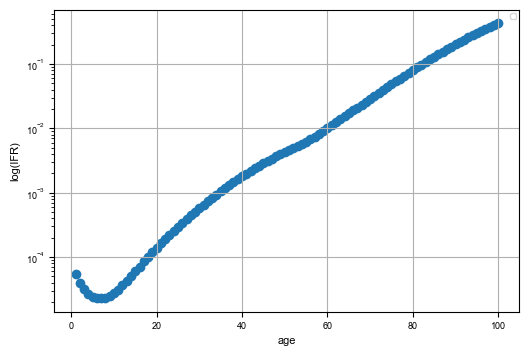

In [18]:
IFR = pd.read_csv('https://github.com/liapla/Game-Theory-and-Epidemics/blob/4657ec535d6c061b5b71959639cf3e4e7aa0b611/ifr_age.txt?raw=true', names=['age','ifr','idk'])   
ds_real = np.array(IFR.ifr)/100

## SEIDV Model

### Constants initialization

In [20]:
R0 = 2              #Basic reproductive ratio
sigma = 1 / 5       #1/Mean latent period
gamma = 1 / 20      #1/Mean infectious period
dv = 1e-6           #Probability of death from vaccine
beta = gamma * R0   #Mean transmission rate 
N = 1               #Normalized population

### SEIDV epidemic model 
In this part we define the epedemic model differential equations and find the numerical solution, using the Runge-Kutta method of order 5.

In [21]:
def SEIDV(t,state): #The differential equations of SEIDV model have been defined in this function
    S,E,I,D,V = state
    dSdt = -beta * S * I -nu
    dEdt = beta * S * I - E * sigma
    dIdt = sigma * E - gamma * I
    dDdt = gamma * I
    dVdt = nu
    return [dSdt , dEdt , dIdt , dDdt , dVdt]
    
def epidemiology_model(S0,E0,I0,D0,V0,t_end): #This function solves epidemic model ODEs with Runge-Kutta method of order 5.
  init = [S0,E0,I0,D0,V0]
  time_span = np.linspace(0.001, 99.99, 100)
  solution = solve_ivp(SEIDV,t_span = (0,t_end),y0=init)
  f_s = interp1d(solution.t,solution.y[0], kind = 'cubic')
  f_e = interp1d(solution.t,solution.y[1], kind = 'cubic')
  f_i = interp1d(solution.t,solution.y[2], kind = 'cubic')
  f_d = interp1d(solution.t,solution.y[3], kind = 'cubic')
  f_v = interp1d(solution.t,solution.y[4], kind = 'cubic')
  Time = np.arange(0,t_end+1)
  Solution = [f_s(Time),f_e(Time),f_i(Time),f_d(Time),f_v(Time)]
  return Solution ,Time

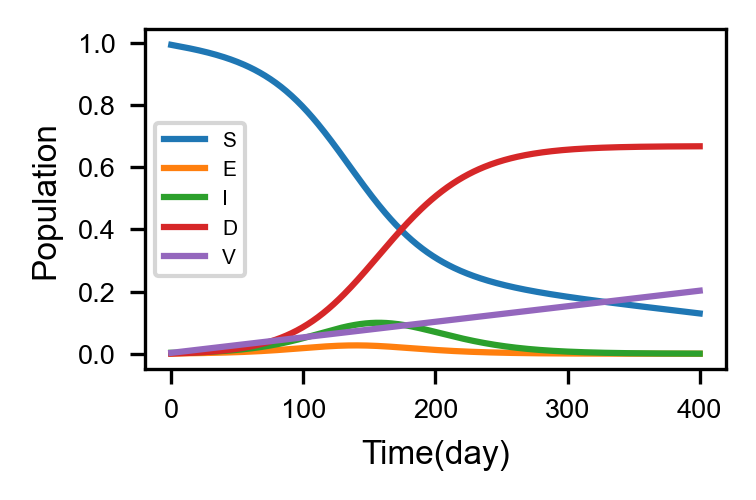

In [22]:
#Model
model , time = epidemiology_model(s0,e0,i0,d0,v0,400)
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(time,model[0] , label = 'S')
ax.plot(time,model[1], label = 'E')
ax.plot(time,model[2], label = 'I')
ax.plot(time,model[3], label = 'D')
ax.plot(time,model[4], label = 'V')
ax.set_ylabel('Population')
ax.set_xlabel('Time(day)')
# ax.set_title('SEIDV epidemiology model')
ax.legend()

plt.show()

# Age dependent decision

In this part, we defined the payoff functions of choosing to get vaccination or not and calculated the critical age, age which has the equal risk from vaccination and Covid-19, from considered situations.

In [25]:
def E_non_vac_time(age,Infectious):
    '''
    Return the payoff function of specific age and population epidemic prediction on range of time

    Parameters:
        age (int): Age
        Infectious (array): Prediction of the number of cumulative infectious over time

    Returns:
        E_non_vac_bytime (array): Payoff function over time of prediction
    '''

    i1 = Infectious[0]
    E_non_vac_bytime = ds_real[age]*(Infectious-i1)[1:]
    return E_non_vac_bytime

def E_non_vac_age(Infectious,t2,t1):
    '''
    Return the payoff function of specific interval of time and population epidemic prediction on range of ages

    Parameters:
        Infectious (array): Prediction of the number of cumulative infectious over time
        t1 (float): Time at the start of the interval
        t2 (float): Time at the end of the interval

    Returns:
        E_non_vac_bytime (array): Payoff function over ages defined on IFR
    '''
    
    i1,i2 = Infectious[t1],Infectious[t2]
    E_non_vac_byage = ds_real*(i2-i1)
    return E_non_vac_byage

Text(0, 0.5, 'Total infectious')

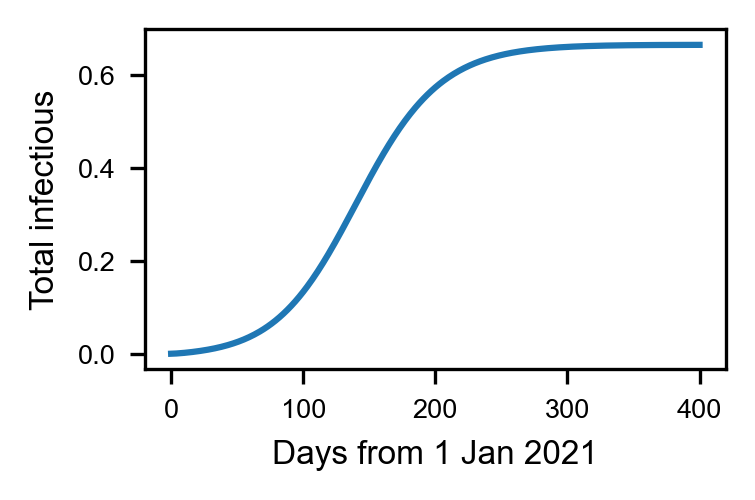

In [24]:
#Graph of the number of cumulative infectious versus time

Infectious = model[2]+model[3]                          #Cumulative infectious is the sum of current infectious and recovered or deaths
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(Infectious-Infectious[0])
ax.set_xlabel('Days from 1 Jan 2021')
ax.set_ylabel('Total infectious')

Graph of the negative values of payoff function of different intervals of time versus ages. The grey dashed line indicated the payoff function of choosing to get vaccinated, and the intersection of colored ($-E_\textrm{nonvac}$) lines and grey ($-E_\textrm{vac}$) line is the Nash equilibria of different time intervals of decision.

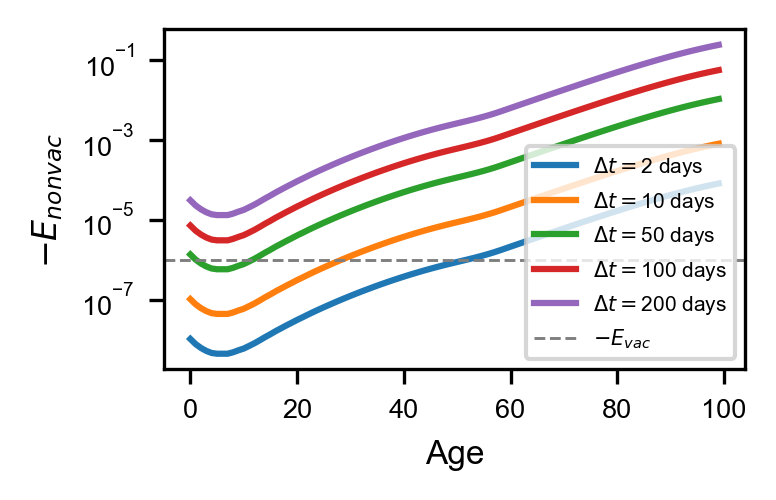

In [19]:
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(-E_non_vac_age(Infectious,0,2),label = '$\Delta t =$2 days')
ax.plot(-E_non_vac_age(Infectious,0,10),label = '$\Delta t =$10 days')
#ax.plot(-E_non_vac_age(Infectious,0,20),label = '20 days')
ax.plot(-E_non_vac_age(Infectious,0,50),label = '$\Delta t =$50 days')
ax.plot(-E_non_vac_age(Infectious,0,100),label = '$\Delta t =$100 days')
ax.plot(-E_non_vac_age(Infectious,0,200),label = '$\Delta t =$200 days')
#ax.plot([0,100],[1e-6,1e-6],label = '$E_{vac}$',ls = '--')
ax.axhline(dv,label = '$-E_{vac}$',ls = '--',color = 'tab:gray',lw = 0.7)
ax.set_yscale("log")
ax.set_xlabel(r'Age')
ax.set_ylabel(r'$-E_{nonvac}$')
ax.legend()

## Critical ages of various intervals of time $\Delta T$

Next, we are going to calculate the Nash equilibrium as the critical age by numerically finding the intersection between the two payoff functions

In [28]:
def NE_time(Infectious,age1,age2):

    '''
    Return the time interval of decision corresponding to every critical ages in range of given ages

    Parameters:
        Infectious (array): Prediction of the number of cumulative infectious over time
        age1 (int): Lower bound of the age range
        age2 (int): Upper bound of the age range

    Returns:
        NE_time (array): Decision time of every critical ages
    '''
    
    Age = np.arange(age1,age2+1)
    dv = 1e-6
    NE_time = []
    for age in Age:
        evac = dv           
        Enonvactime = E_non_vac_time(age,Infectious)
        if max(Enonvactime) < dv: ne_time = 100
        elif min(Enonvactime) > dv: ne_time = 0
        else:
            fun = interp1d(np.arange(1,len(Infectious)),Enonvactime-evac)
            ne_time = fsolve(fun,x0 = 50)              
        #print(ne_time)
        NE_time.append(ne_time)
    return NE_time

Then we plotted the graph of the relationship of critical ages (upper) and the time interval of decision starting from 1 Jan, 2021.

/Users/ambasscope/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/var/folders/ft/_tx7cb7j5594443_xhsg6y4r0000gn/T/ipykernel_9476/2273781709.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.plot(np.array(NE_time(Infectious,age1,age2))/7,np.arange(age1,age2+1))


(0.0, 80.0)

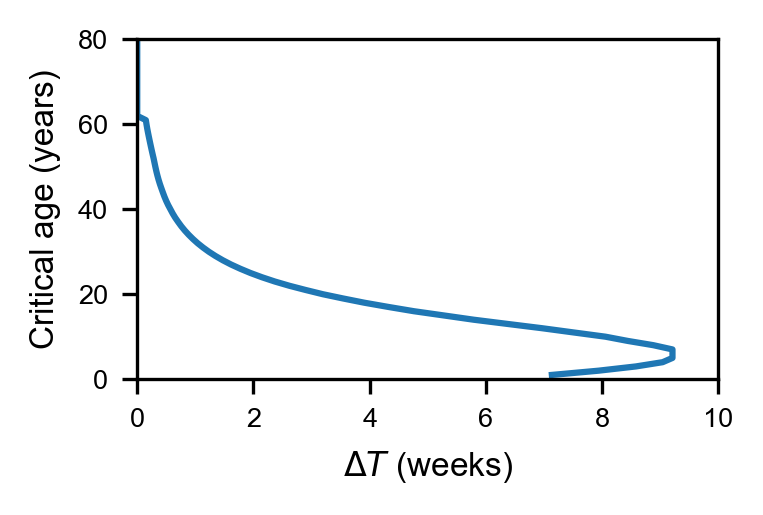

In [29]:
age1 = 1
age2 = 80
fig ,ax = plt.subplots(1,1,figsize = (2.5,1.5))
ax.plot(np.array(NE_time(Infectious,age1,age2))/7,np.arange(age1,age2+1))
ax.set_ylabel('Critical age (years)')
ax.set_xlabel('$\Delta T$ (weeks)')
ax.set_xlim([0,10])
ax.set_ylim([0,80])

## Fixed size of window of decision

For the last part, we fixed the interval of decision to be 1 month and calculated the critical ages over the course of epidemics (one year starting from 1 Jan, 2021)

In [30]:
def NE_age(Infectious,delta_t,t_end):

    '''
    Return the critical age corresponding to the specific decision interval and each times in the studied interval

    Parameters:
        Infectious (array): Prediction of the number of cumulative infectious over time
        delta_t (int): Decision interval
        t_end (int): The number of day from the first day as the last day of studied interval

    Returns:
        NE_age (array): Critical ages of everty time in the studied interval
    '''

    Time = np.arange(len(Infectious))
    Time = Time[Time<t_end-delta_t]
    dv = 1e-6
    NE_age = []
    for time in Time:
        ds_crit = dv/(Infectious[time+delta_t]-Infectious[time])
        fun = interp1d(np.arange(1,101),ds_real-ds_crit)
        try: ne_age = fsolve(fun,x0=50)
        except: 
            try: ne_age = fsolve(fun,x0=2)
            except: 
                ne_age = 0
        NE_age.append(ne_age)
    return NE_age


Then we plotted the graph of the relationship of critical ages (upper) and the number of daily cases (lower) as functions of the number of day from 1 Jan, 2021.

/Users/ambasscope/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[]

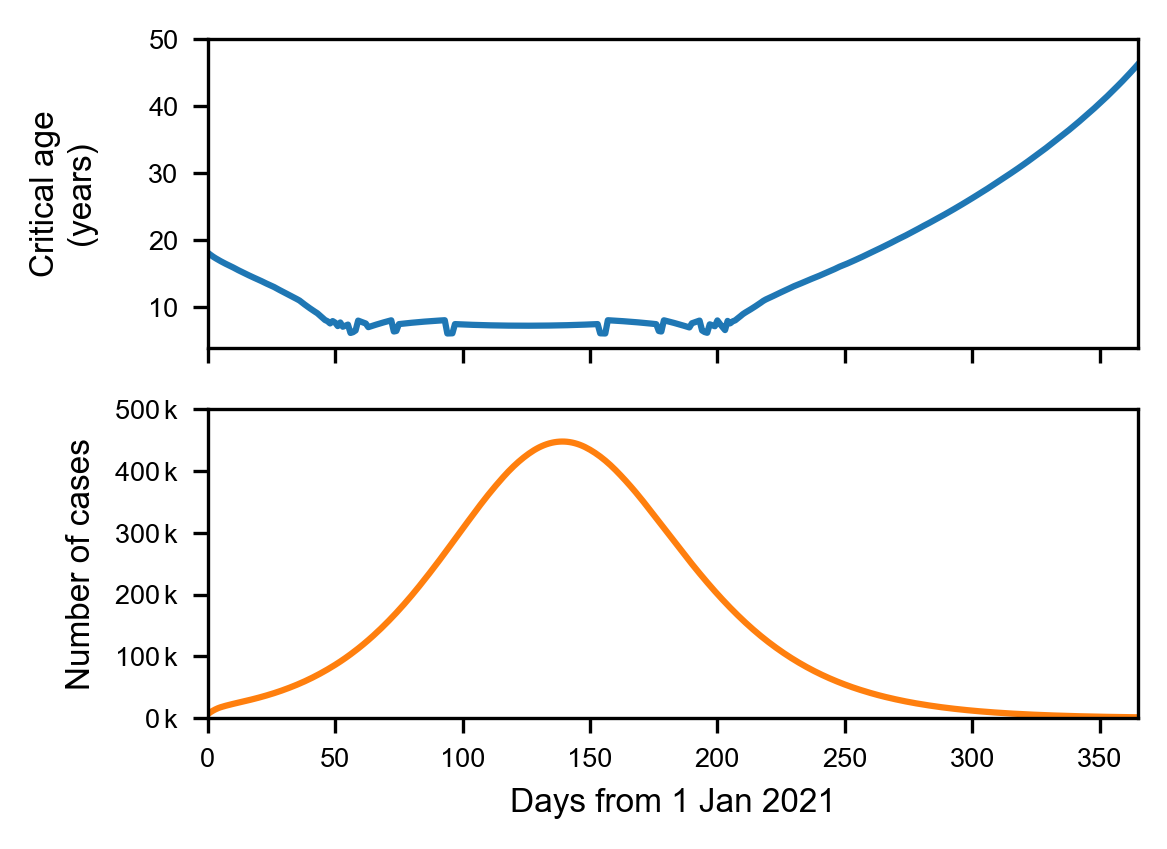

In [32]:
fig , ax = plt.subplots(2,1,figsize=(4,3))
ax[0].plot(NE_age(Infectious,delta_t,t_end))
ax[0].set_ylabel('Critical age\n(years)')
ax[0].set_xlim([0,365])
ax[0].set_xticklabels([])

ax[1].plot(np.diff(Infectious)*p0, color = 'tab:orange')
ax[1].set_xlabel('Days from 1 Jan 2021')
ax[1].set_ylabel('Number of cases')
ax[1].set_xlim([0,365])
ax[1].set_ylim([0,5e5])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,_: str(int(x/1000)) +'$\,$k'))


# ax2 = ax[1].twinx()
# ax2.plot(Infectious, color = 'tab:red')
# ax2.set_ylabel('Cumulative cases', color = 'tab:red')

fig.align_ylabels(ax)
plt.plot()